# EXPLORATORY DATA ANALYSIS (I.)

In [66]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)


In [67]:
predictors = [
    'L3',
    'L2',
    'L1',
    'CF_CL',
    'CASH_TA',
    'SAL_TA',
    'TL_SAL',
    'INV_COST',
    'INV_SAL',
    'CC_SAL',
    'TA_SAL',
    'TL_TA',
    'CF_TL',
    'CL_TA',
    'NCL_TA',
    'EQ_TL',
    'EQ_TA',
    'CL_CC',
    'ROE',
    'EAT_TA',
    'ROA_BRUTTO',
    'CF_TA',
    'CF_SAL',
    'ROS',
    'EAT_YIE',
    'ROI',
    'ROA_NETTO',
    'LABOR_PRODUCTIVITY',
    'SOCLIAB_SAL']

print(len(predictors))

29


In [68]:
DISTRESS_CRITERIA_1Y_OFF = [
 'DPHZ_vat_registration_cancelled_1y_off',
 'RUZ_indirect_criterion_1y_off',
 'RU_konkurz_1y_off',
 'RU_ostatne_konania_1y_off',
 'RUZ_cancelled_1y_off']


DISTRESS_CRITERIA_2Y_OFF = [
 'DPHZ_vat_registration_cancelled_2y_off',
 'RUZ_indirect_criterion_2y_off',
 'RU_konkurz_2y_off',
 'RU_ostatne_konania_2y_off',
 'RUZ_cancelled_2y_off']

In [69]:
financial_ratios_table_raw = pd.read_csv('../../DATA/FINAL/training_data.csv')
display(financial_ratios_table_raw.shape[0])

C:\Users\matus.rohal\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3433: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


1679947

In [70]:
def combined_issue_2y_off(row):
    if row.DPHZ_vat_registration_cancelled_2y_off == 1: return 1
    if row.RUZ_cancelled_2y_off == 1: return 1
    if row.RU_konkurz_2y_off == 1: return 1
    if row.RU_ostatne_konania_2y_off == 1: return 1
    return 0


def combined_issue_1y_off(row):
    if row.DPHZ_vat_registration_cancelled_1y_off == 1: return 1
    if row.RUZ_cancelled_1y_off == 1: return 1
    if row.RU_konkurz_1y_off == 1: return 1
    if row.RU_ostatne_konania_1y_off == 1: return 1
    return 0


financial_ratios_table_raw['direct_criterion_2y_off'] = financial_ratios_table_raw.apply(combined_issue_2y_off, axis = 1)
financial_ratios_table_raw['direct_criterion_1y_off'] = financial_ratios_table_raw.apply(combined_issue_1y_off, axis = 1)

In [71]:
financial_ratios_table_raw.query('period_length == 12 and is_outlier == False')['year'].value_counts()

2021    228941
2020    222994
2019    212053
2018    200862
2017    187263
2016    176749
2015    171918
2014    167507
Name: year, dtype: int64

In [89]:
data_2017 = financial_ratios_table_raw.query('year == 2017 and sal_class in ["1. Mikro", "2. Malý", "3. Stredný"] and period_length == 12 and financial_report_template_id == 699')
data_2018 = financial_ratios_table_raw.query('year == 2018 and sal_class in ["1. Mikro", "2. Malý", "3. Stredný"] and period_length == 12 and financial_report_template_id == 699')

In [90]:
def get_sample_sizes(data, row_label, column_label):
    samples_df = data.groupby([row_label, column_label])['financial_statement_id'].nunique().to_frame('count').reset_index()
    wide_df = pd.pivot_table(samples_df, index = row_label, columns=column_label, fill_value=0)
    return wide_df

In [91]:
counts_table = get_sample_sizes(data_2017, 'sknace_division', 'RUZ_indirect_criterion_2y_off').reset_index()
counts_table.columns = ['sknace_division', 'healthy', 'distressed']
counts_table['total'] = counts_table['healthy'] + counts_table['distressed']
counts_table['distressed_ratio'] = 100 * counts_table['distressed'] / counts_table['total']
counts_table.sort_values('total', ascending=False)

sknace_groups = ['G', 'C', 'F', 'H', 'M', 'N', 'L']

# G - VEĽKOOBCHOD A MALOOBCHOD OPRAVA MOTOROVÝCH VOZIDIEL A MOTOCYKLOV
# C - Priemyselná výroba
# F - STAVEBNÍCTVO
# H - DOPRAVA A SKLADOVANIE
# M - ODBORNÉ VEDECKÉ A TECHNICKÉ ČINNOSTI
# N - ADMINISTRATÍVNE A PODPORNÉ SLUŽBY
# L - ČINNOSTI V OBLASTI NEHNUTEĽNOSTÍ

In [92]:
# financial_ratios_table_raw = financial_ratios_table_raw.query('entity_ico in @master_set')
# financial_ratios_table_raw

In [93]:
SAL_CLASSES = sorted(data_2017['sal_class'].unique())
# SKNACE_GROUPS = data_2017['sknace_division'].unique()
SKNACE_GROUPS = ['G', 'C', 'F', 'H', 'M', 'N', 'L']

In [94]:
from sklearn.impute import SimpleImputer


def fill_missing_values_mean(data):
    # Instantiate SimpleImputer with mean strategy
    imputer = SimpleImputer(strategy='mean')

    # Fit the imputer on the data and transform the data
    imputed_data = imputer.fit_transform(data)

    return imputed_data

financial_ratios_table_2017 = pd.DataFrame()

for sal_class in SAL_CLASSES:
    for sknace in SKNACE_GROUPS:
        # print(f'sales_class: {sal_class}; sknace: {sknace}')
        subset = data_2017.query('sal_class == @sal_class and sknace_division == @sknace')
        if subset.shape[0] < 10:
            continue
        for col in predictors:
            col_mean = subset[col].mean()
            subset[col].fillna(col_mean)

        financial_ratios_table_2017 = pd.concat([financial_ratios_table_2017, subset], axis = 0)

display(financial_ratios_table_2017.shape[0])




financial_ratios_table_2018 = pd.DataFrame()

for sal_class in SAL_CLASSES:
    for sknace in SKNACE_GROUPS:
        # print(f'sales_class: {sal_class}; sknace: {sknace}')
        subset = data_2018.query('sal_class == @sal_class and sknace_division == @sknace')
        if subset.shape[0] < 10:
            continue
        for col in predictors:
            col_mean = subset[col].mean()
            subset[col].fillna(col_mean)

        financial_ratios_table_2018 = pd.concat([financial_ratios_table_2018, subset], axis = 0)

display(financial_ratios_table_2018.shape[0])

34354

34525

In [95]:
group_column = 'sal_class'

display(
    pd.concat(
        [
            
            financial_ratios_table_2017
            .groupby([group_column])
            ['financial_statement_id'].nunique()
            .to_frame('sample_size'),
            
            financial_ratios_table_2017.query('RUZ_indirect_criterion_2y_off == 1')
            .groupby([group_column])
            ['financial_statement_id'].nunique()
            .to_frame('indirect_indicator_count'),
            
            financial_ratios_table_2017.query('direct_criterion_2y_off == 1')
            .groupby([group_column])
            ['financial_statement_id'].nunique()
            .to_frame('direct_indicator_count'),

            financial_ratios_table_2017.query('is_outlier == False')
            .groupby([group_column])
            ['financial_statement_id'].nunique()
            .to_frame('sample_size_clean'),
            
            financial_ratios_table_2017.query('is_outlier == False and RUZ_indirect_criterion_2y_off == 1')
            .groupby([group_column])
            ['financial_statement_id'].nunique()
            .to_frame('indirect_indicator_count_clean'),
            
            financial_ratios_table_2017.query('is_outlier == False and direct_criterion_2y_off == 1')
            .groupby([group_column])
            ['financial_statement_id'].nunique()
            .to_frame('direct_indicator_count_clean'),

        ], axis = 1
        ).reset_index())

,sal_class,sample_size,indirect_indicator_count,direct_indicator_count,sample_size_clean,indirect_indicator_count_clean,direct_indicator_count_clean
0,1. Mikro,27433,3585,434,27002,3483,402
1,2. Malý,5464,322,97,5403,312,87
2,3. Stredný,1457,62,26,1444,61,23


## Data distribution

In [96]:
def plot_histograms(df, columns, filter_out_outliers = True):
    # Plotting the histograms
    fig, axes = plt.subplots(nrows=int(len(columns) / 3) + 1, ncols=3, figsize=(20, 30))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        ax = axes[i]


        data = df.query(f'{column} == {column}')[column]
        
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        if filter_out_outliers:
            cleaned_data = data[~((data < lower_bound) | (data > upper_bound))]
        else:
            cleaned_data = data

        bin_width = 2 * IQR / (len(cleaned_data) ** (1/3))

        num_bins = int(np.ceil((np.max(cleaned_data) - np.min(cleaned_data)) / bin_width))

        sns.histplot(cleaned_data, bins=num_bins, kde=True, color='skyblue', edgecolor='black', ax=ax)
        # sns.kdeplot(cleaned_data, color='red', ax=ax, linewidth=2)  # Adding KDE plot
        ax.set_title(column)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

    # Hide empty subplots
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

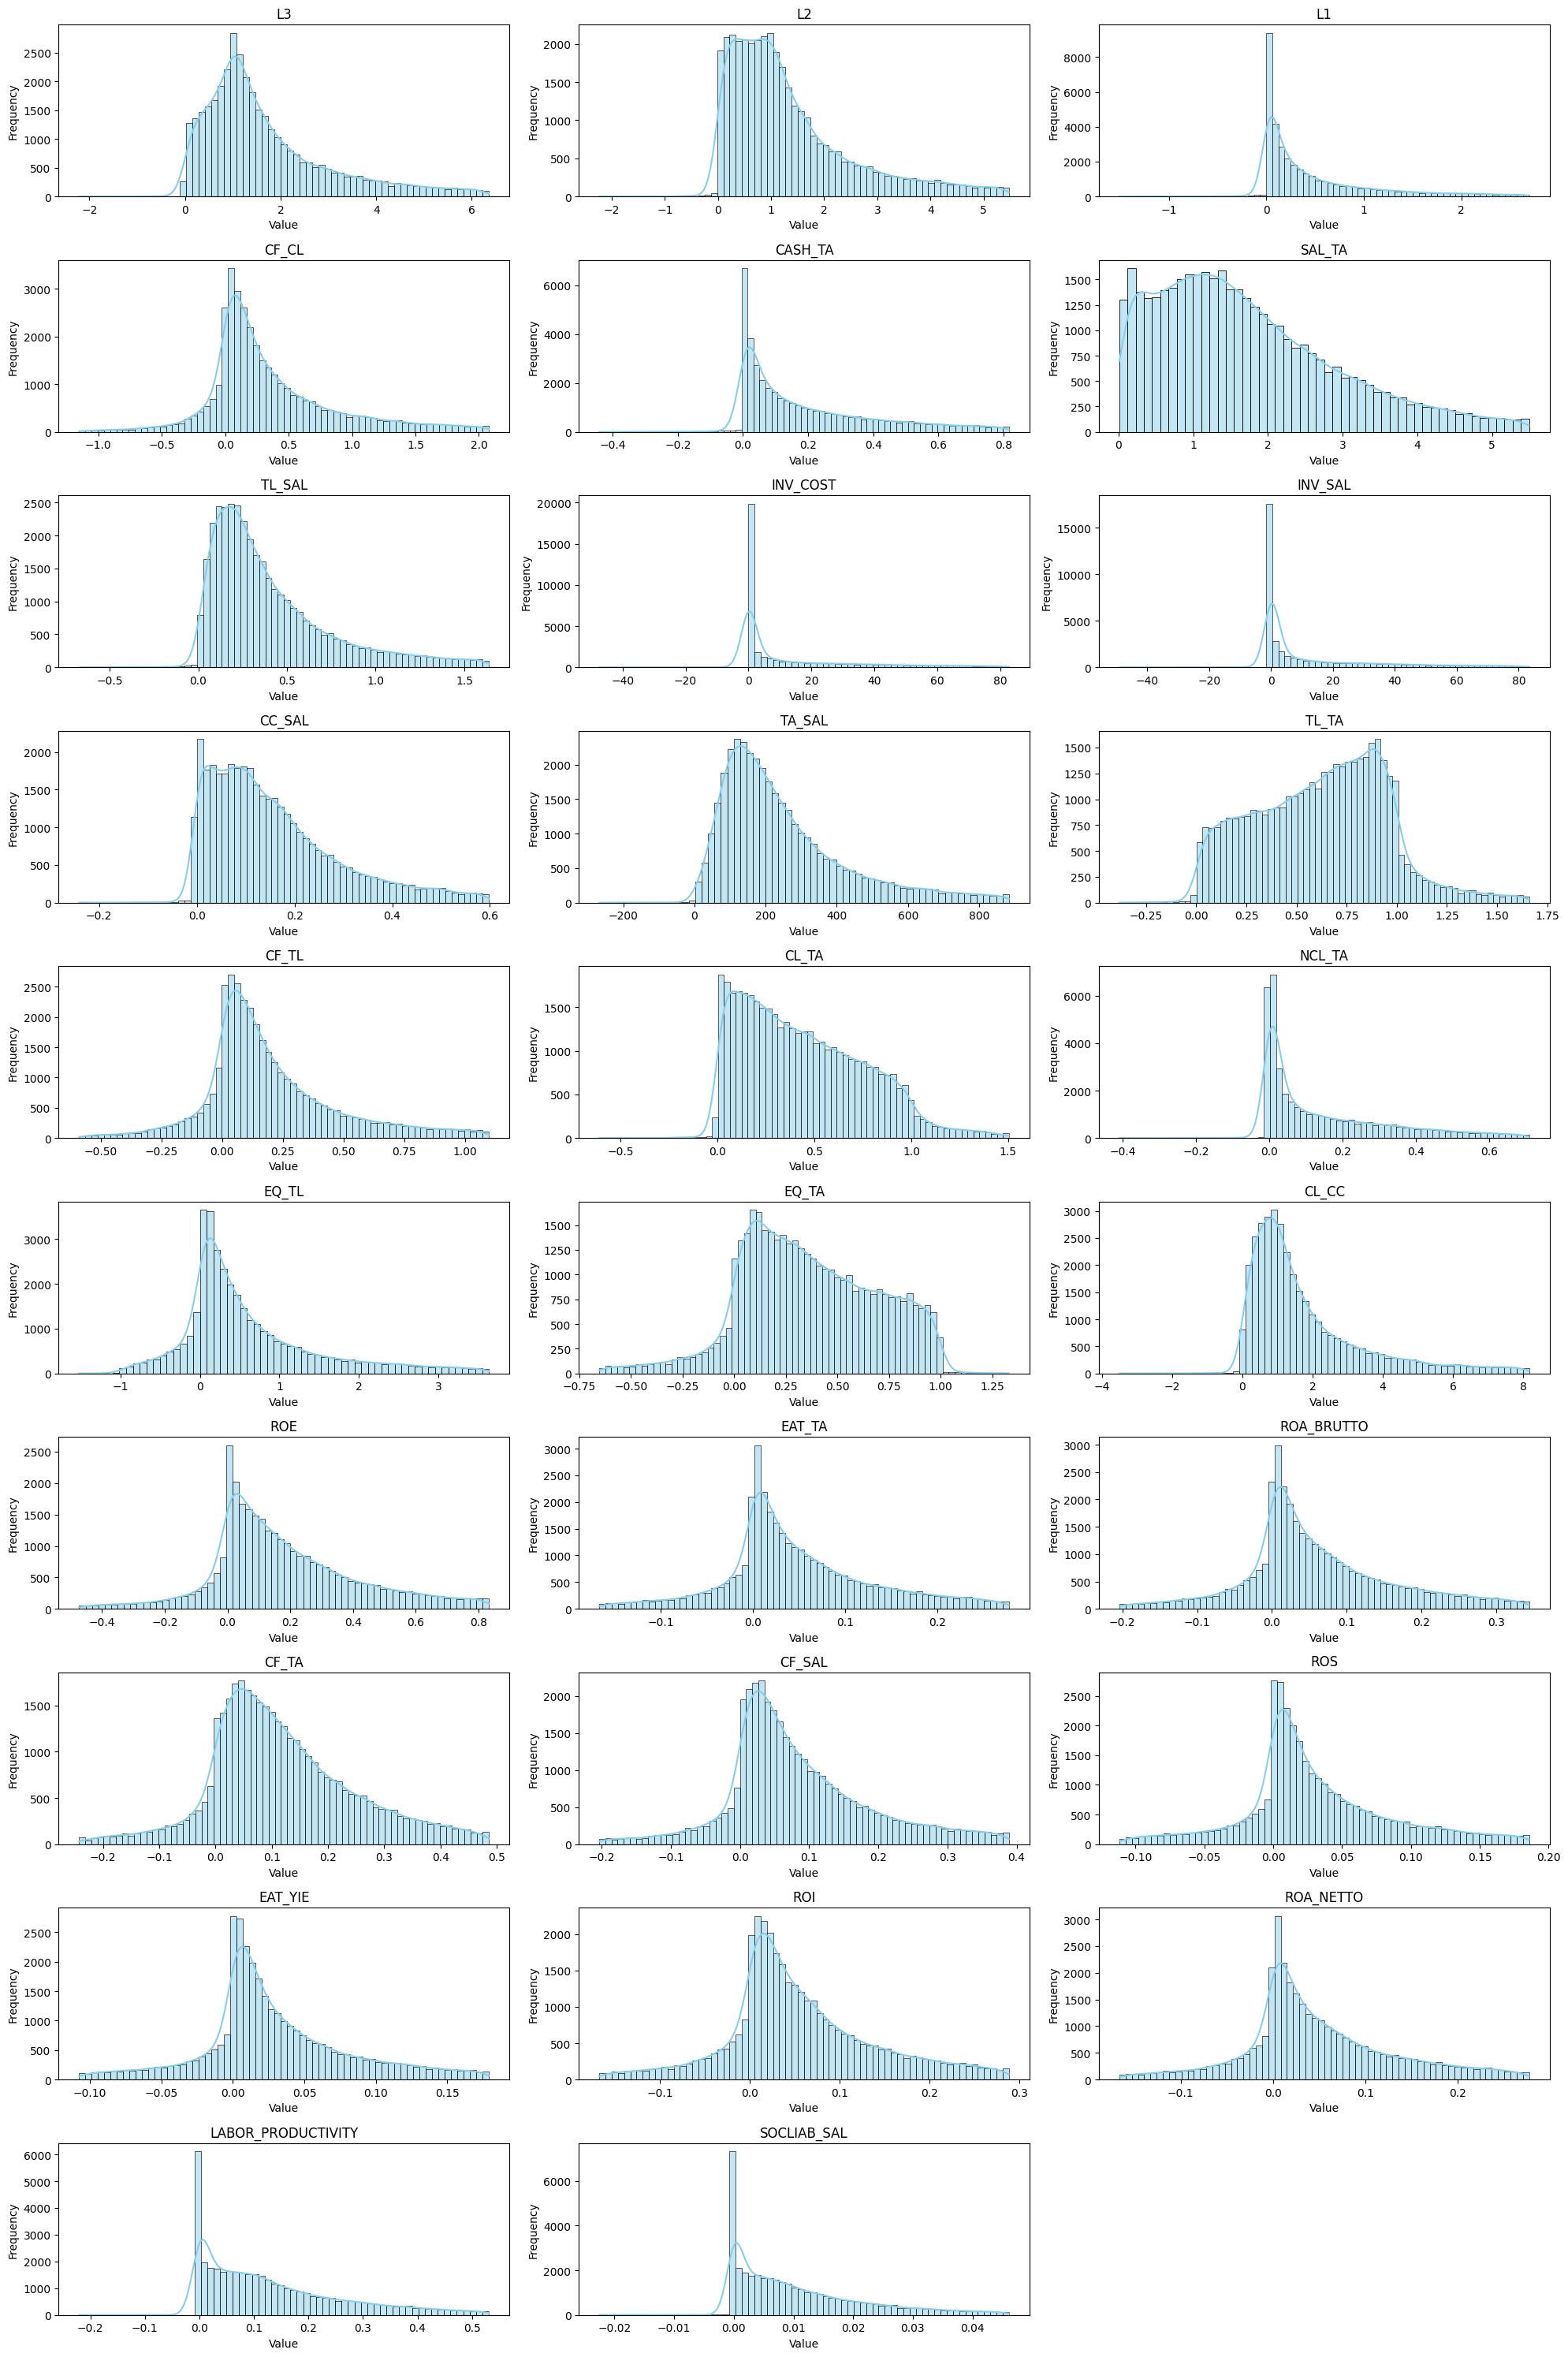

In [98]:
# plot_histograms(financial_ratios_table.query('year == 2018'), predictors)
plot_histograms(data_2018.query('is_outlier == 0'), predictors)

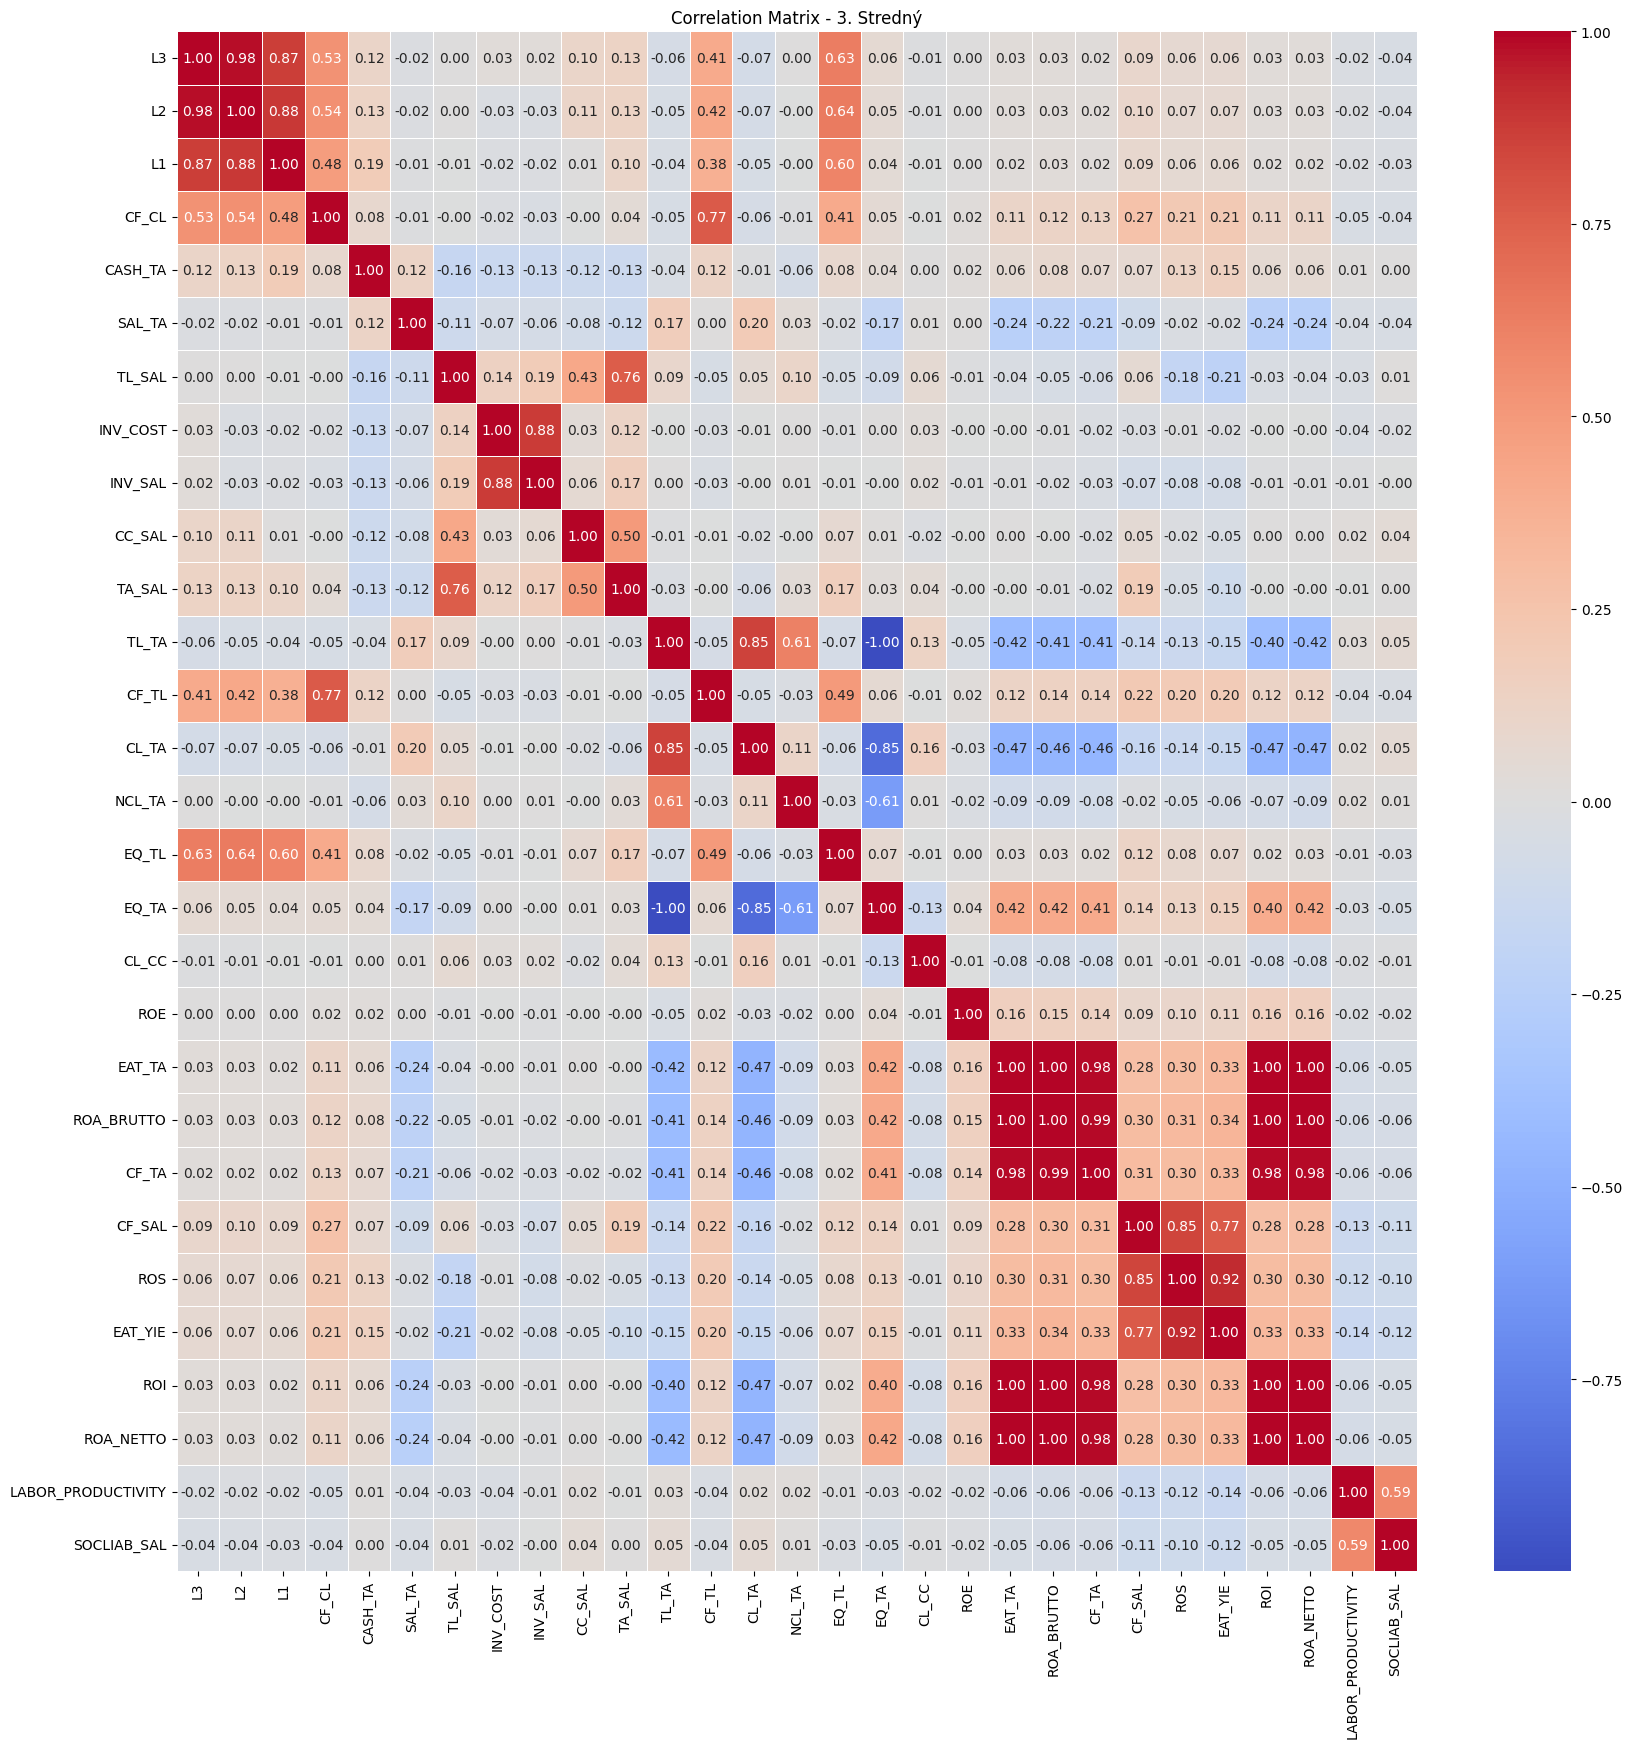

In [100]:
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = financial_ratios_table_2017.query('is_outlier == False')[predictors].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title(f'Correlation Matrix - {sal_class}')
plt.show()

In [101]:
import pandas as pd
import statsmodels.api as sm

def calculate_vif(data):
    # Add a constant term to the independent variables matrix
    X = sm.add_constant(data)

    # Compute VIF for each feature
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [1 / (1 - sm.OLS(X[col], X.drop(columns=[col])).fit().rsquared) for col in X.columns]
    vif_data['VIF'] = vif_data['VIF'].apply(lambda x: round(x, 2))

    return vif_data



vif_result = calculate_vif(pd.DataFrame(fill_missing_values_mean(financial_ratios_table_2017[predictors]), columns=predictors))
display(vif_result)

vif_result = calculate_vif(pd.DataFrame(fill_missing_values_mean(financial_ratios_table_2017[['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL', 'LABOR_PRODUCTIVITY', 'SOCLIAB_SAL']]), columns=['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL', 'LABOR_PRODUCTIVITY', 'SOCLIAB_SAL']))
display(vif_result)

C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_9476\1400906885.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  vif_data['VIF'] = [1 / (1 - sm.OLS(X[col], X.drop(columns=[col])).fit().rsquared) for col in X.columns]


,Feature,VIF
0,const,66.54
1,L3,50.73
2,L2,59.11
3,L1,5.02
4,CF_CL,4.08
5,CASH_TA,1.02
6,SAL_TA,29.44
7,TL_SAL,1.56
8,INV_COST,1.18
9,INV_SAL,1.32


,Feature,VIF
0,const,1.66
1,SAL_TA,27.45
2,ROE,1.00
3,ROA_NETTO,3.17
4,TL_TA,38.06
5,CASH_TA,1.00
6,ROS,1.08
7,NCL_TA,11.77
8,TL_SAL,1.03
9,LABOR_PRODUCTIVITY,1.08


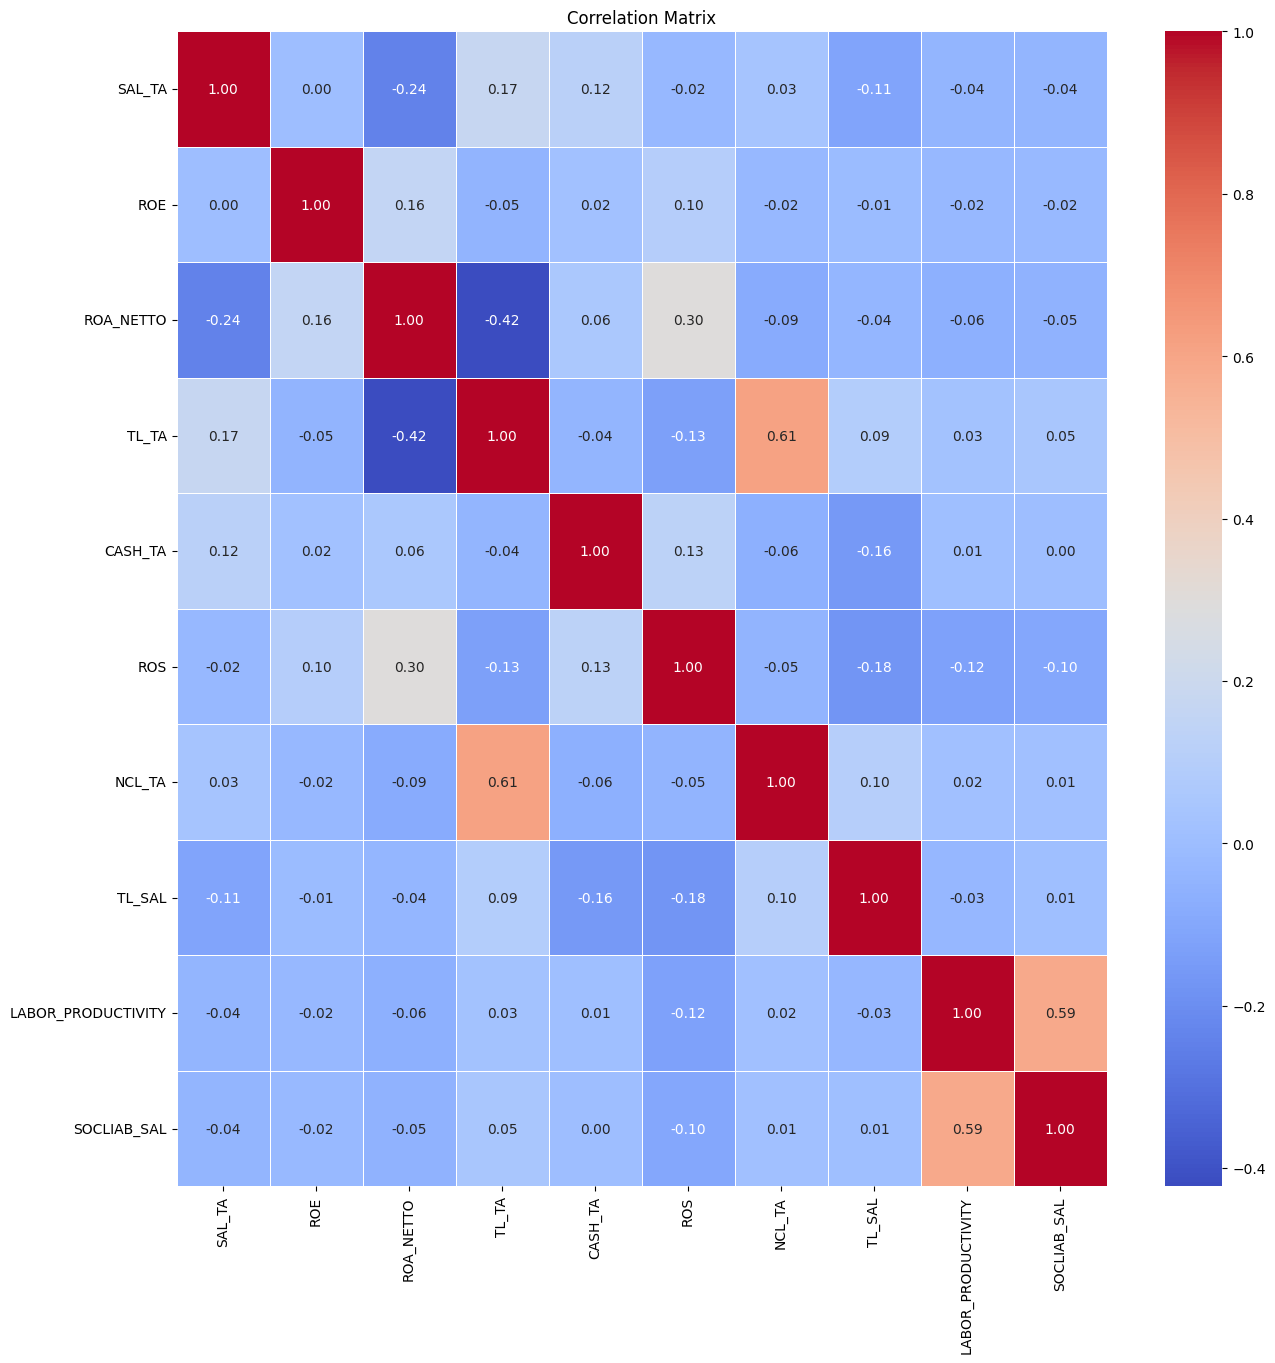

In [102]:
# Calculate the correlation matrix
correlation_matrix = financial_ratios_table_2017.query('is_outlier == False')[['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL', 'LABOR_PRODUCTIVITY', 'SOCLIAB_SAL']].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title(f'Correlation Matrix')
plt.show()

## Models

### Logistic Regression

c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8185479129923574
Precision: 0.04706853839801817
Recall: 0.41424418604651164
F1 Score: 0.08453210737060655
ROC AUC Score: 0.6205686308847703
Balanced Accuracy: 0.6205686308847703


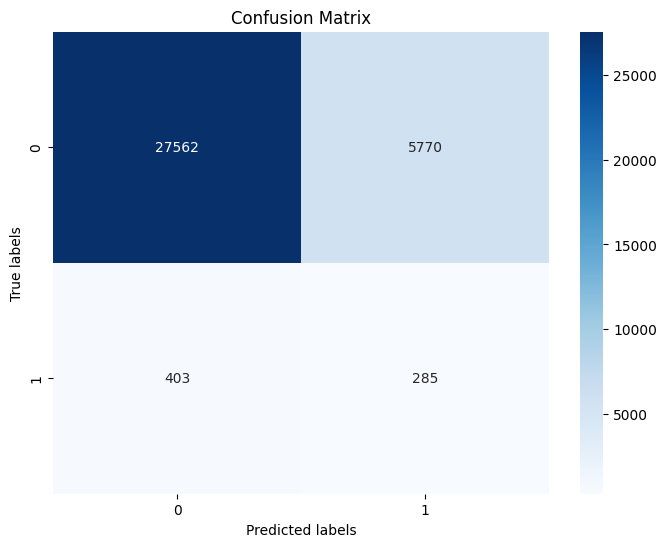

In [112]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Generating some sample data with imbalanced classes

# X =  fill_missing_values_mean(financial_ratios_table_2017.query('is_outlier == False')[['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL', 'LABOR_PRODUCTIVITY', 'SOCLIAB_SAL']].values)
# y =  financial_ratios_table_2017.query('is_outlier == False')['direct_criterion_2y_off'].fillna(1).values

# # Splitting the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train =  fill_missing_values_mean(financial_ratios_table_2017.query('is_outlier == False')[['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL', 'LABOR_PRODUCTIVITY', 'SOCLIAB_SAL']].values)
y_train =  financial_ratios_table_2017.query('is_outlier == False')['direct_criterion_2y_off'].fillna(1).values

X_test =  fill_missing_values_mean(financial_ratios_table_2018.query('is_outlier == False')[['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL', 'LABOR_PRODUCTIVITY', 'SOCLIAB_SAL']].values)
y_test =  financial_ratios_table_2018.query('is_outlier == False')['direct_criterion_2y_off'].fillna(1).values

# Creating SMOTE and RandomUnderSampler objects
smote = SMOTE(sampling_strategy='auto', random_state=42)
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Creating logistic regression model
logistic_model = LogisticRegression()

# Creating a pipeline to combine sampling and modeling
pipeline = Pipeline([('SMOTE', smote), ('RUS', rus), ('Logistic Regression', logistic_model)])

# Fitting the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predicting on the testing set
y_pred = pipeline.predict(X_test)

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Print all evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Balanced Accuracy:", balanced_accuracy)

# Generating and plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Decision Tree

Accuracy: 0.8705761316872428
Precision: 0.031052764453420853
Recall: 0.17877906976744187
F1 Score: 0.05291460529146053
ROC AUC Score: 0.5318172319916052
Balanced Accuracy: 0.5318172319916052


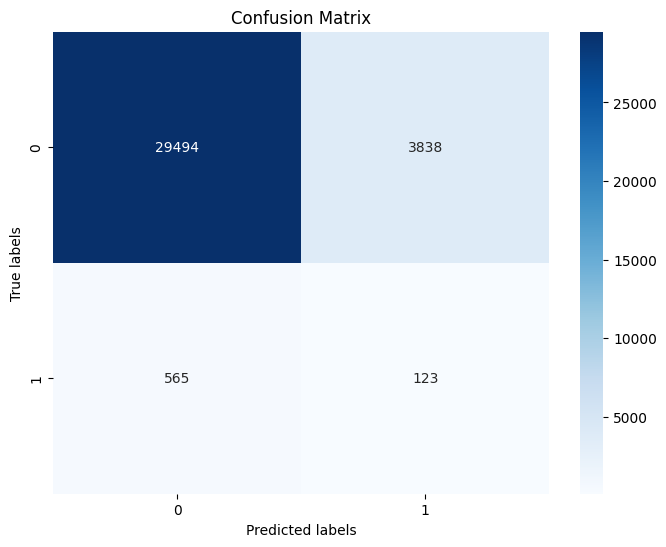

In [113]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


# Creating Decision Tree classifier
tree_model = DecisionTreeClassifier(criterion="gini")

# Creating a pipeline to combine sampling and modeling
pipeline = Pipeline([('SMOTE', smote), ('RUS', rus), ('Decision Tree', tree_model)])

# Fitting the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predicting on the testing set
y_pred = pipeline.predict(X_test)

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Print all evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Balanced Accuracy:", balanced_accuracy)

# Generating and plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Support Vector Machine

Accuracy: 0.9193121693121693
Precision: 0.060657838530542504
Recall: 0.2063953488372093
F1 Score: 0.0937603169362826
ROC AUC Score: 0.5702113549658265
Balanced Accuracy: 0.5702113549658265


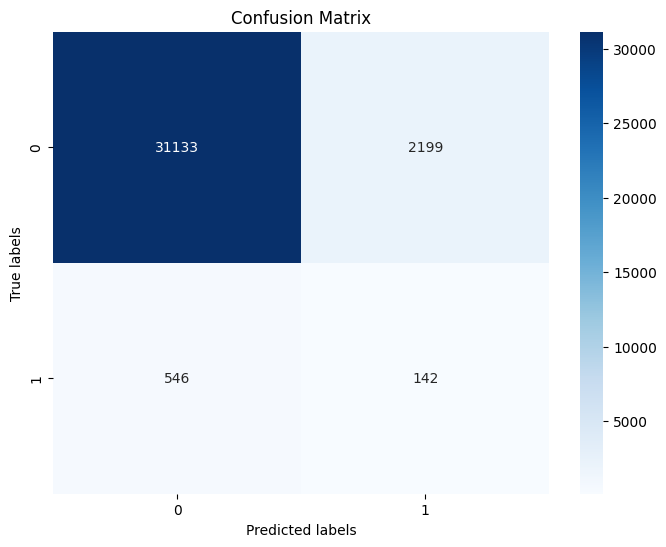

In [114]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline



# Creating SVM classifier
svm_model = SVC(kernel='linear')  # You can choose different kernels such as 'linear', 'rbf', 'poly', etc.

# Creating a pipeline to combine sampling and modeling
pipeline = Pipeline([('SMOTE', smote), ('RUS', rus), ('SVM', svm_model)])

# Fitting the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predicting on the testing set
y_pred = pipeline.predict(X_test)

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Print all evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Balanced Accuracy:", balanced_accuracy)

# Generating and plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


### Neural Net

Shape of X_train_resampled: (66674, 10)
1064/1064 [==============================] - 1s 916us/step
Accuracy: 0.7256319811875367
Precision: 0.03695372750642673
Recall: 0.501453488372093
F1 Score: 0.06883479648842776
ROC AUC Score: 0.6158563493702539
Balanced Accuracy: 0.6158563493702539


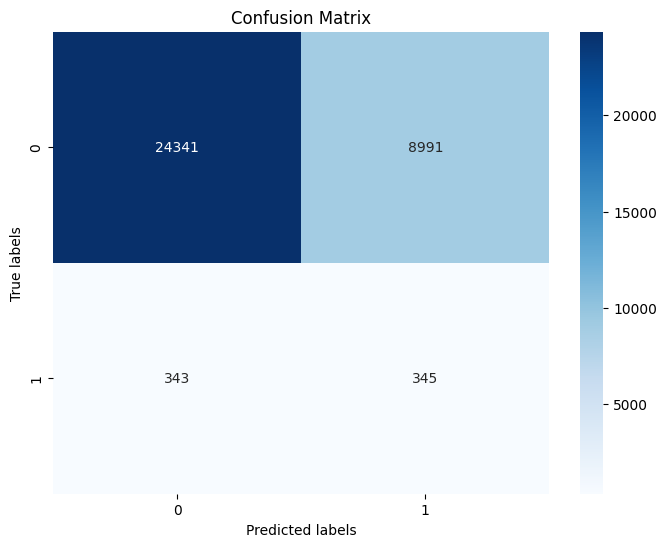

In [115]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense


# Reshape y_train to match the expected shape for Keras
y_train = y_train.reshape(-1, 1)


# Creating a neural network classifier
model = Sequential()
model.add(Dense(10, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Creating a pipeline to combine sampling and modeling
pipeline = Pipeline([('SMOTE', smote), ('RUS', rus)])

# Fitting the pipeline on the training data
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Check the shape of X_train_resampled
print("Shape of X_train_resampled:", X_train_resampled.shape)

# Creating a neural network classifier
model = Sequential()
# Adjust the input shape based on the actual number of features in X_train_resampled
model.add(Dense(10, input_dim=X_train_resampled.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the neural network on the resampled data
model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=10, verbose=0)

# Predicting on the testing set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


# Print all evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Balanced Accuracy:", balanced_accuracy)

# Generating and plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()